# Working with Outliers
## By: Karim Zakir

### Introduction
Datasets can often contain outliers - points which are unlike or far from most of the data. There are several reasons these datapoints can appear in datasets. They can either represent unusual observations or errors in data-entry (Bose, n.d.). Either way, they can greatly affect the accuracy of a machine learning model or statistical analysis in general. As such, during data preprocessing, one of the objectives is to detect the outliers in the dataset; however, despite the potential negative effects on future analysis, removing all of the identified outliers is the wrong choice. Outliers can serve as helpful indicators to possible trends that the analyst may have overlooked or point to exceptions that can be quite important for the scientist's model. We should aim to remove only outliers, which are clearly data-entry errors or extremely unrealistic, since those are not helpful to the analysis whatsoever (Widmann, Heine and Silipo, n.d.). 

Outlier detection can prove challenging, because every dataset has different data and different data distributions; thus, it is essential to know a variety of outlier detection techniques. In this notebook, we will focus on four techniques: the numeric outlier technique, Cook's Distance, Mahalanobis Distance, and the Density-Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm. These four methods are quite different from each other, and should provide us with a good toolset to detect outliers in a variety of datasets. Note that all of these methods are non-parametric techniques of outlier detection, since we cannot always make assumptions about the distribution of the data.

For this notebook, I will use the [Brazilian Houses To Rent](https://www.kaggle.com/dataset/0fc2c2957155f98e380a0e5e7db219aff29962b37b13e6ac5a569389cfe26e83/version/1) dataset obtained from Kaggle. This dataset is perfect for this notebook, since it contains data-entry errors, while also containing observations which are most-likely accurate, but are unusual for the dataset. 

In order to understand how effective each of the methods are, we will take a closer look at the observations that were identified as outliers and gain insight from those observations. Additionally, we will also optimize some of the techniques to gain a deeper understanding of how to use the methods and how effective they are in detecting outliers. Finally, after applying a technique to the dataset, we will also weigh its pros and cons and reach a conclusion about the outlier detection method.  

Let's start by importing all of the necessary libraries and taking a quick look at the dataset...

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the dataset and assigning its length to a variable
houses = pd.read_csv("datasets/houses_to_rent_v2.csv")
original_length = len(houses)
houses.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [3]:
# The floor column has some non-numerical values ('-'), these will be replaced by 0, since I am assuming that '-' indicates a single-story house and 
# does not indicate missing data
houses.replace({"-": 0}, inplace=True)
houses["floor"] = houses["floor"].astype(int)
# Apart from this, there is no other potentially missing data in the dataset

# Only selecting numeric columns
houses = houses.select_dtypes(include=np.number)

### Numeric Outlier Technique
The Numeric Outlier Technique will be arguably the simplest method within this notebook. For this non-parametric method, we need to calculate the first and third quartiles, as well as the interquartile range (IQR). We then calculate the upper and lower 'bounds' of the dataset. The upper bound is calculated by adding the IQR multipled typically by 1.5 to the third quartile. Similarly, the lower bound is calculated by subtracting the IQR multipled by 1.5 from the first quartile. Any point that lies below or above the lower bound and the upper bound respectively is considered an outlier. By having the IQR multiplier be 1.5, the upper and lower bounds will correspond to the upper and lower whiskers in a boxplot. Here is the formula visualized:
<p align="center">
    <img src="https://www.kdnuggets.com/wp-content/uploads/ouotlier-detection-eq1.jpg" alt="Numeric Outlier Formula">
</p>

(Widmann, Heine and Silipo, n.d.)

Since this method only works on a one dimensional space, we will apply this method to each **numeric** column individually.

In [4]:
# Getting the observations which are identified as outliers by the Numeric Outlier Technique
numeric_cols = houses.columns.tolist()
k = 1.5
to_remove = {} # will contain indexes of observations to be removed from each column
for col in numeric_cols:
    quantiles = houses[[col]].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0, 0]
    q3 = quantiles.iloc[1, 0]
    iqr = q3 - q1
    lower_bound = q1 - k*iqr
    upper_bound = q3 + k*iqr
    num_out_outliers_index = houses[(houses[col] > upper_bound) | (houses[col] < lower_bound)].index
    to_remove[col] = num_out_outliers_index

In [5]:
# Determining the amount of observations removed
# I am using sets, since certain observations may have been removed, because of several columns
combined = set()
for indexes in to_remove.values():
    combined.update(set(indexes))
print("Removed:", len(combined))
print(f"This is {len(combined) / original_length * 100}% of our dataset")

Removed: 2216
This is 20.725776281331836% of our dataset


The numeric outlier technique has identified 2216 observations as outliers, which is approximately 21% of our dataset. This is an unusually high figure for outlier detection, since a fifth of a dataset cannot be considered outliers. Nevertheless, let's take a closer look at these records by creating a statistical summary for each of the columns. The columns for the summary table are going to be independent of each other; this means that if an observation was removed because of a very high/low value in a particular column, we will only be considering the value in that column and not others.

In [6]:
# Getting a slice of the data containing only outliers for each column
num_out_outliers = houses.loc[list(combined)]
custom_groups = {}
for key, values in to_remove.items():
    removed_obsv = houses.loc[values]
    custom_groups[key] = removed_obsv

In [7]:
# Preparing to create a summary table
summary_table = pd.DataFrame(["mean", "count", "min", "max", "std"], columns=["metric"])
summary_table.set_index("metric", inplace=True)
for key in custom_groups.keys():
    summary_table[key] = np.NaN

In [8]:
# Populating the summary table
for key, group in custom_groups.items():
    summary_table.loc["mean", key] = group[key].mean()
    summary_table.loc["count", key] = group[key].count()
    summary_table.loc["min", key] = group[key].min()
    summary_table.loc["max", key] = group[key].max()
    summary_table.loc["std", key] = group[key].std()
summary_table

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
metric,,,,,,,,,,
mean,643.555060,5.490196,7.271845,6.909938,23.462094,7.864637e+03,13315.286713,2013.290472,180.704574,2.176261e+04
count,672.000000,408.000000,103.000000,322.000000,277.000000,7.170000e+02,715.000000,1081.000000,809.000000,7.060000e+02
min,372.000000,5.000000,7.000000,6.000000,19.000000,2.847000e+03,10250.000000,881.000000,139.000000,1.384000e+04
max,46335.000000,13.000000,10.000000,12.000000,301.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06
std,2056.965563,0.950832,0.674380,1.008358,17.135104,5.979513e+04,2257.772698,9602.811547,36.650247,6.085062e+04


This statistical summary provides us with quite a bit of insight into the observations which were identified as outliers. Firstly, as evident by the maximum metrics, we have removed observations with (most-likely) data-entry errors, such as the observations in the area or floor column. However, the minimum metrics perfectly show why the interquartile range multiplier was too low. Some of the values which were removed from the rooms or floor columns are realistically too low to be considered data-entry errors or even valid outliers in the real world. Interestingly, the column with the most outliers was the property tax column. It is not immediately clear why that is, because, logically, this column should correlate with the rent amount (R$) column. Perhaps, the property tax in Brazil is progressive, making the tax for more expensive apartments much higher than for low-cost housing. 

As shown by the summary table, the IQR multiplier is clearly too low to properly identify outliers. We should increase the upper bound by increasing the IQR multiplier. This will allow us to detect more 'unrealstic' observations. However, it is not immediately clear what that multiplier should be. Thus, we will steadily increase the multiplier until we have identified one percent of the dataset as outliers. The reason why I have chosen one percent is because this small value will identify observations which are the most further from 'normal' data, making them outliers. We will also plot how many observations were identified as outliers as we increased our IQR mutliplier; this will provide us with insight into how the data is distributed in the dataset.

In [9]:
# Saving the quantiles and the IQR for each column in the dataset
quantiles_dict = {}
for col in numeric_cols:
    quantiles = houses[[col]].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0, 0]
    q3 = quantiles.iloc[1, 0]
    iqr = q3 - q1
    quantiles_dict[col] = [q1, q3, iqr]

In [10]:
# Steadily increasing the IQR mutlitplier so that less than 1% of the dataset is removed
currently_removed = len(combined)
removed_count = [len(combined)]
removed_indexes = {}
k_lst = [k]
one_percent = int(0.01 * original_length) # finding the one percent length of the data
while currently_removed > one_percent:
    k += 0.5
    k_lst.append(k)
    for col in numeric_cols: # identifyin outliers with IQR multiplier equal to k
        q1 = quantiles_dict[col][0]
        q3 = quantiles_dict[col][1]
        iqr = quantiles_dict[col][2]
        lower_bound = q1 - k*iqr
        upper_bound = q3 + k*iqr
        num_out_outliers_index = houses[(houses[col] > upper_bound) | (houses[col] < lower_bound)].index
        to_remove[col] = num_out_outliers_index

    combined = set()
    for indexes in to_remove.values():
        combined.update(set(indexes))
    removed_indexes[k] = list(combined)
    currently_removed = len(combined)
    removed_count.append(currently_removed)
k # printing the final k

8.0

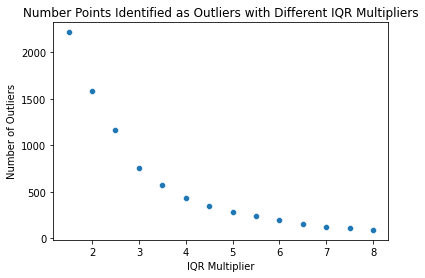

In [11]:
# Plotting the number of points identified as outliers against the IQR mutlitpliers that we tested
ax = sns.scatterplot(x=k_lst, y=removed_count)
ax.set(xlabel="IQR Multiplier", ylabel="Number of Outliers", title="Number Points Identified as Outliers with Different IQR Multipliers")
plt.show()

The IQR multiplier that we reached is 8. I am not sure if there is any particular significance behind this number. It is quite high, though, which can suggest that the data is quite spread out. This is also confirmed by the plot above.

When we began increasing the IQR multiplier,the amount of observations identified as outliers decreased rapdily; however, the decrease then levels off and becomes more steady. This suggests that there is a large cluster of observations grouped together, which are 'located' beyond the traditional whiskers of the boxplot. In turn, this discovery allows us to identify those points as non-outliers, since points within a larger group or cluster cannot be really considered as outliers. Instead, it is most-likely a group of high-class houses, and not anomalies. Then, the level-off suggests that those clusters are reducing in size. This suggests that high-class houses are not as popular in the Brazilian rent market as middle-class apartments are, which realistically makes sense. Finally, the 100 observations that are quite far from the median and the general group of observations can possibly be outliers, so let's take a closer look at them by creating another summary table.

In [12]:
# Creating a summary table for the new batch of outliers
summary_table = pd.DataFrame(["mean", "count", "min", "max", "std"], columns=["metric"])
summary_table.set_index("metric", inplace=True)
k = 8
for col in numeric_cols:
    quantiles = houses[[col]].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0, 0]
    q3 = quantiles.iloc[1, 0]
    iqr = q3 - q1
    lower_bound = q1 - k*iqr
    upper_bound = q3 + k*iqr
    num_out_outliers = houses[(houses[col] > upper_bound) | (houses[col] < lower_bound)]
    summary_table[col] = np.NaN
    summary_table.loc["mean", col] = num_out_outliers[col].mean()
    summary_table.loc["count", col] = num_out_outliers[col].count()
    summary_table.loc["min", col] = num_out_outliers[col].min()
    summary_table.loc["max", col] = num_out_outliers[col].max()
    summary_table.loc["std", col] = num_out_outliers[col].std()
summary_table

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
metric,,,,,,,,,,
mean,12981.857143,13.0,NaN,NaN,301.0,2.366817e+05,45000.0,9506.712329,564.000000,4.517486e+05
count,7.000000,1.0,0.0,0.0,1.0,1.200000e+01,1.0,73.000000,2.000000,7.000000e+00
min,1600.000000,13.0,NaN,NaN,301.0,9.900000e+03,45000.0,3084.000000,451.000000,5.443000e+04
max,46335.000000,13.0,NaN,NaN,301.0,1.117000e+06,45000.0,313700.000000,677.000000,1.120000e+06
std,17068.054863,NaN,NaN,NaN,NaN,4.177959e+05,NaN,36308.076670,159.806133,4.648481e+05


Based on the above summary table, the most notable change is that now no observations were identified as outliers because of the bathroom or parking spaces columns, and only one or two observations were identified as outliers based on the rooms, rent amount and fire insurance columns. Most observations identified as outliers were detected in the propert tax column. This reinforces the idea from above that the property tax in Brazil is possibly quite progressive. This argument is further supported by the standard deviation for the column. Additionally, we still managed to catch the observations with clear data-error entries, as evident by the maximum row for the area, floor, and total columns. However, some observations can still cause confusion. For instance, the minimum value for property tax, is realistically not too high, which could suggest it is a real observation. This shows that perhaps it is better to increase the IQR mutliplier separately for each column. This, however, will require more time and processing power. Furthermore, it is not immediately clear what value the IQR mutlitplier should be for each column and how to determine that value. This also forces us to question and choose how many observations we want to be identified as outliers for every column; this is a question that does not have a clear answer or even a clear method to obtain the answer. 

### Numeric Outlier Technique Conclusion

The Numeric Outlier technique is an incredibly simple method for identifying outliers in a dataset. It is cheap in terms of processing power and does not require too much coding. Its simplicity is great for medium-sized datasets with focused distributions and observations. Additionally, due to its one-dimensional nature, it is great for datasets with a small number of features or columns that are not necessarily related to each other.

The simplicity, however, also causes certain problems. For instance, as we saw with our dataset, we have identified approximately 20% of our dataset to be outliers using the standard IQR multiplier. This led us to modfying the multiplier until less than one percent of the dataset was identified as outliers, requiring more code and making the method less intuitive. It also means that in order to obtain optimal results, you will most likely need to tweak the IQR multiplier for different datasets. The disadvantage is especially clear if you are going to modify the IQR multiplier for each column individually, which may be required with certain datasets or columns. Given the unpredictability of real-life data, this makes the technique unsuitable for immediate use for most datasets out there. Its biggest weakness, however, is that it does not consider the relationships between the columns, which can prove quite important, especially without contextual knowledge about the dataset. For example, consider a house whose area is 50 square meters, but which has 4 bathrooms according to your data. In the context of their individual columns, the two figures make sense; however, together, they become an anomaly and a possible data-entry error, since it is unlikely a house with a relatively small area has that many bathrooms. This is where multivariate outlier detection comes in. 

In particular, this is where Mahalanobis Distance can be incredibly useful to detect outliers in the dataset.

### Mahalanobis Distance 
Mahalanobis Distance is a distance metric, which finds the distance between a point and its distribution. It uses the inverse of a covariance matrix of variables in the combination with the data's center to find the distance, which means that it detects outliers based on the pattern of data points (Cansiz, 2020). Since this method can find distances in multidimensional spaces, it is great as a multivariate outlier detection technique. This is the formula to find Mahalanobis Distance:

![Mahalanobis Distance](https://www.machinelearningplus.com/wp-content/uploads/2019/04/3_Mahalanobis_Distance_Formula-min.png?ezimgfmt=ng:webp/ngcb3)

(Prabhakaran, n.d.)

where:
- $D$ is the Mahalanobis Distance
- $x$ is the point
- $m$ is the center
- $C$ is the covariance matrix

After we find the Mahalanobis Distance, it is important to find a cut-off point using the Chi-Square distribution. The reason why the Chi-Square distribution is used is because the formula returns the Mahalanobis Distance squared (Cansiz, 2020). In order to calculate the Mahalanobis Distance, we are going to be using the approproate function from the scipy package; however, the function returns the result after finding the square root, so we will be squaring the results manually. Let's get started...

In [13]:
# Finding the inverse of the covariance matrix and the data's center
inv_cov = np.linalg.matrix_power(houses.cov(), -1)
mean = np.mean(houses)
mahalanobis_houses = houses.copy()
mahalanobis_houses["mahalanobis_distance"] = np.NaN

In [14]:
# Adding the distance to the copy of the dataset
for index, values in mahalanobis_houses.iterrows():
    values = values[0:10]
    mahalanobis_houses.loc[index, "mahalanobis_distance"] = mahalanobis(values, mean, inv_cov)**2

In [15]:
# Finding the 0.99 cut-off (two-tailed) and identifying outliers
# n-1 degrees of freedom where n is the number of columns in the dataset
mahalanobis_threshold = chi2.ppf(0.99, mahalanobis_houses.shape[1] - 1)
mahalanobis_outliers = mahalanobis_houses[mahalanobis_houses["mahalanobis_distance"] > mahalanobis_threshold].index
print("Removed:", len(mahalanobis_outliers))
print(f"This is {len(mahalanobis_outliers) / original_length * 100}% of our dataset")

Removed: 374
This is 3.4979423868312756% of our dataset


As you can see, using the two-tailed 0.01 cut-off, we have removed 374 observations, which is approximately 3.5% of the original dataset. This is a much better immediate result when compared to the numeric outlier technique. We will take a closer look at these observations; however, I will not calculate the same statistical summary as last time, since it is better to look at the observations observation fully instead of simply getting a summary of the overall data. Thus, we will look at a sample of observations.

In [16]:
houses.loc[mahalanobis_outliers].sample(n=20, random_state=20)

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
4896,150,6,5,8,0,0,8000,625,132,8757
2055,998,7,10,4,0,0,15000,5000,226,20230
8307,500,8,5,2,0,0,11000,1550,166,12720
2831,999,5,7,4,0,100,15000,459,226,15790
2589,400,3,4,5,0,0,8500,309,152,8961
6731,616,5,5,6,0,0,12500,1103,205,13810
4621,350,7,4,2,0,0,8000,1250,121,9371
1381,420,4,3,4,0,0,15000,1250,226,16480
1976,210,5,4,1,0,0,15000,1667,226,16890
2709,105,1,1,2,29,1300,8700,417,111,10530


Firstly, as expected, the Mahalanobis Distance has identified several observations, for which the features make little sense when put together. For instance, in observation 9822, the amount of parking spaces provided seems to be too high for the given area and amount of rooms. It is somewhat difficult to determine whether this is a factual observation or a data-entry error, since I have no knowledge about the Brazilian real estate markets; however, if we look at other observations in the table, the amount of parking spaces provided seems to be more appropriate for the amount of rooms in the apartment. Still, though, it is important to look at other datapoints with similar values in order to remove such observations. Additionally, Mahalanobis Distance has identified the observations containing what look like data-entry errors, such as observation 255, which can be confidently removed. There are, however, observations, which we cannot confidently call data-entry errors or even outliers, such as observations 6731 or 1467. Such observations will require further investigation and analysis in order to determine whether they should be removed from the dataset. It could be worth also using other multivariate outlier detection techniques and see if the same observations are identified as outliers.

### Mahalanobis's Distance Conclusion
Mahalanobis Distance is a useful outlier detection technique. One of its strengths is that it works well with multivariate data, which is what we encounter most in the real world. This allows you to detect outliers without much of the contextual knowledge of the dataset, as we have seen previously with the Brazilian houses dataset. It is also quick to implement and does not require much coding, especially if you use the scipy function. Most importantly, though, unlike Euclidean Distance, it considers the distribution of the data and accounts for the variance of said data, which makes it a great alternative to Euclidean Distance, which can often incorrectly identify outliers. Finally, due to its nature, it is well optimized right away and requires very little tuning; the most that a user has to do is to determine the cut-off using the Chi-square distribution. Due to its multivariate nature, however, it becomes hard to visualize this method, making it less intuitive. It is possible to see the interaction of two different columns in a two-dimensional graph, but visualization gets quite difficult or even impossible past that point. In turn, this leads to another disadvantage: it can be hard to know exactly why an observation was identified as an outlier. This makes the decision of whether to remove an observation even harder, since you may not possess all of the necessary information. This creates a need for a metric which is intuitive, no matter the dimensions or the size of the dataset. To get this metric, we are going to look at Cook's Distance, another outlier detection technique.

### Cook's Distance
Cook's Distance is used as an estimate of a data point's influence when conducting least-squares regression analysis. The intuition behind Cook's Distance is that the more influential a point is relative to other points during regression analysis, the more likely it is to be an outlier, which negatively affects the performance of the model (Pineda, 2020). The formula to calculate a point's Cook's Distance i.e influence is: 

$$D_i = (r_i^2 / p*MSE) * (h_{ii} / (1-h_{ii})^2)$$

where:
- $r_i$ is the i<sup>th</sup> residual
- $p$ is the number of coefficients in the regression model
- $MSE$ is the mean squared error
- $h_{ii}$ is the i<sup>th</sup> leverage value

(How to Identify Influential Data Points Using Cook's Distance - Statology, 2019)

Once we find each observation's influence, we also have to set a threshold, which will determine whether a datapoint's influence is too high or not. Traditionally, 4/n is used as a threshold, where n is the number of observations (How to Identify Influential Data Points Using Cook's Distance - Statology, 2019)
. We will stick with this.


Although the formula is quite complicated, we will not have to apply it directly. We are going to use the statsmodel package, which will provide us with Cook's Distance for each observation when we train a linear regression model. Our target will be the total rent column, while all of the other numeric columns will be the featues. Note that during actual analysis, not all columns of the dataset should be used as features; however, creating an efficient model is outside of the scope of this notebook.

In [17]:
# Preparing our features and target
features = houses.columns[0:9]
target = houses.columns[9]
X = houses[features]
y = houses[target]

In [18]:
# Training a model and getting Cook's Distance for each point
X = sm.tools.tools.add_constant(X)
sm_model = sm.regression.linear_model.OLS(y, X).fit()
influence = sm_model.get_influence()
influence_list = influence.cooks_distance[0]
influence_df = pd.DataFrame(influence_list, columns=["influence"])
influence_df.index = houses.index
cooks_df = houses.merge(influence_df, left_index=True, right_index=True)

In [19]:
# Settin the threshold and getting the outliers
cooks_threshold = 4/original_length
cooks_outliers = cooks_df[cooks_df["influence"] > cooks_threshold]
print("Removed:", len(cooks_outliers))
print(f"This is {len(cooks_outliers) / original_length * 100}% of our dataset")

Removed: 23
This is 0.2151141040029929% of our dataset


In [20]:
len(cooks_outliers) / original_length * 100

0.2151141040029929

Using Cook's Distance, we have only identified 23 outliers, which makes up a tiny 0.22% of our original dataset. This is the smallest amount of observations identified as outliers so far. Let's take a look at them and try to understand exactly why they were identified as outliers. Additionally, we will sort the observations in the ascending order of influence to see how the observations correlate with Cook's Distance.

In [21]:
cooks_outliers.sort_values(by=["influence"])

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),influence
8187,700,4,10,0,0,0,15000,8750,226,23980,0.000407
2182,700,4,7,8,0,0,45000,8750,677,54430,0.000432
4813,1600,4,5,12,0,1,6900,5000,104,12010,0.000448
10416,350,3,3,3,0,0,15000,667,267,15930,0.000496
1893,540,6,8,3,0,0,15000,467,267,15730,0.000533
6519,330,4,4,2,21,1300,15000,1084,110,17490,0.000704
7835,439,13,4,3,0,0,15000,667,229,15900,0.000713
8969,238,4,5,3,1,2500,15000,375,58,17930,0.001255
1699,700,4,4,4,0,0,10000,21880,151,32040,0.001417
9425,45,2,1,1,25,375,1756,0,23,2176,0.001822


Similarly to previous outlier detection techniques, we have identifed some observations with extreme values, which result in high influence scores. They are most-likely data-entry errors and should be removed from the dataset. There are also some interesting observations, such as observation 4994. There seems to be nothing outright wrong with the observation - no value is too extreme and the columns even make sense when considered together; however, its Cook's Distance is the second highest in the entire dataset. I think this particular observation shows the strength of Cook's Distance. It can detect observations, whose features do not fit the same pattern as other observations do. This is perfect for when you have linear relationships within your dataset, but have little contextual knowledge about it. It is important to note, though, that this works well only for linear relationships, since we have used linear regression analysis. Despite this, however, it still might be difficult to remove certain observations, as further analysis will most likely be required to confirm Cook's Distances measurements. For instance, for observation 4994, it would be useful to check the average values for the total column for similar feature values. This would allow us to understand how  unlikely the values are for the observation. We will try this approach right now.

We are going to filter the dataset, so that our values are approximately the same as the values in the observation 4994.

In [22]:
filtered_houses = houses[(houses["area"] >= 89) & (houses["area"] <= 99)]
filtered_houses = filtered_houses[(filtered_houses["rooms"] >= 2) & (filtered_houses["rooms"] <= 4)]
filtered_houses = filtered_houses[(filtered_houses["bathroom"] >= 1) & (filtered_houses["bathroom"] <= 5)]
filtered_houses = filtered_houses[(filtered_houses["parking spaces"] >= 1) & (filtered_houses["parking spaces"] <= 3)]
filtered_houses = filtered_houses[(filtered_houses["hoa (R$)"] >= 700) & (filtered_houses["hoa (R$)"] <= 800)]
filtered_houses = filtered_houses[(filtered_houses["rent amount (R$)"] >= 2333) & (filtered_houses["rent amount (R$)"] <= 2533)]
filtered_houses = filtered_houses[(filtered_houses["property tax (R$)"] >= 0) & (filtered_houses["property tax (R$)"] <= 100)]
filtered_houses = filtered_houses[(filtered_houses["fire insurance (R$)"] >= 21) & (filtered_houses["fire insurance (R$)"] <= 41)]
filtered_houses.drop(labels=[4994], axis=0)

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
6175,92,3,2,3,1,752,2525,0,32,3309


In [23]:
cooks_df.loc[6175]["influence"]

3.638316051425077e-08

This is a surprising result. The features for observation 6175 are numerically quite close, even the target variable is numerically close; however, its Cook's Distance is incredibly smaller than the Cook's Distance for observation 4994. This is because the hoa, rent amount, property tax, and fire insurance columns do not perfectly add up to the total column for the 4994th observation, but they do so for observation 6175. Although this shows why Cook's Distance would be so high for observation 4994, it still doesn't make sense to remove the observation, because the difference is insignificant in the real world. This shows how essential it is to analyze the potential outliers in more detail, instead of just removing them right away.

### Cook's Distance Conclusion

As we have seen, Cook's Distance works well with linear regression. It allows us to know how influential each point is during analysis, making Cook's Distance much more intuitive and simple when compared to Mahalanobis Distance. Similar to Mahalanobis Distance, though, it is great for working with multivariate data and can often provide interesting insights into the data. It is important to note, however, that Cook's Distance works best only if there's a linear relationship between the features and the target variable. Otherwise, Cook's Distance may not work as well as intended. Perhaps, in case that only a few features have a linear relationship with the target variable, it is best to isolate those features and use Cook's Distance to identify outliers only within those columns. 

In today's notebook, we have mostly looked at statistical measurements to find outliers; however, we have not looked at machine learning algorithms in order to detect anomalies within the data. In particular, let's take a look at the DBSCAN, a clustering algorithm capable of detecting outliers, in addition to classifying data.

### DBSCAN (Density Based Spatial Clustering of Applications with Noise)

DBSCAN is a clustering algorithm, meaning that it classifies given data into automatically-determined categories, based on the Euclidean Distance between datapoints. One of the categories that the algorithm can identify are outliers (Santoyo, 2017). DBSCAN is available in the sci-kit learn package. 

The algorithm has two parameters: eps and min_samples. Eps, which stands for epsilon, is the maximum distance that a datapoint can be from another datapoint in order to be considered part of the same class. Min_samples, which stands for minimum samples, is the minimum number of datapoints in the epsilon radius of another datapoint needed for it to be considered a core point; this includes the point itself (Santoyo, 2017).

We will use this clustering algorithm in order to identify outliers in our dataset. At first, we will use the default parameters; however, later, we will optimize the algorithm in order to best fit our dataset.

In [24]:
# Initializing and training the model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(houses)

DBSCAN()

In [25]:
# Getting the amount of observations identified as outliers
# They are labelled with -1
unique = []
outlier_count = 0
for value in dbscan.labels_:
    if value not in unique:
        unique.append(value)
    if value == -1:
        outlier_count += 1
print("Removed:", outlier_count)
print(f"This is {outlier_count / original_length * 100}% of our dataset")

Removed: 10589
This is 99.03666292555181% of our dataset


As you can see, if we keep the parameters at their default values, then the algorithm identifies 10589 observations as outliers, which is over 99% of our dataset. Obviously, this is unacceptable, so we should optimize the algorithm in order to fit our dataset. 

As mentioned previously, there are two main parameters that we can modify: epsilon and minimum samples. Perhaps, the minimum samples parameter can be increased further; however, in my opinion, the default value is appropriate for our dataset, given that our target is to identify the most unlikely observations. Thus, we should focus on the epsilon value. It is not immediately clear, however, what the epsilon value should be. So, we will steadily increase it by 250 until the algorithm has identifed less than one percent of our dataset as outliers. I am picking a relatively high value for the epsilon increase, since, as we have seen previously in the numeric outlier technique sections, the observations in our data are spread out.

In [26]:
currently_removed = outlier_count
eps = 1
min_samples = 5
removed_lst = []
eps_lst = []
while currently_removed > one_percent:
    eps_lst.append(eps)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(houses)
    labels_df = pd.DataFrame(dbscan.labels_, columns=["labels"])
    labels_df.index = houses.index
    removed_df = labels_df[labels_df["labels"] == -1]
    removed_indexes = removed_df.index
    currently_removed = len(removed_indexes)
    removed_lst.append(currently_removed)
    eps += 150
eps

1501

In [27]:
currently_removed

98

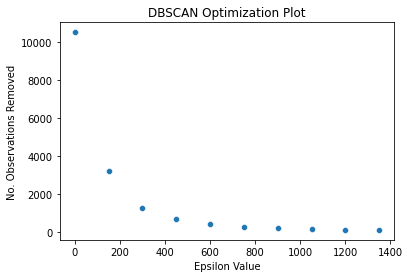

In [28]:
ax = sns.scatterplot(x=eps_lst, y=removed_lst)
ax.set(xlabel="Epsilon Value", ylabel="No. Observations Removed", title="DBSCAN Optimization Plot")
plt.show()

Our experiment shows that the appropriate epsilon value for the dataset is 1501; using this value, we have identified 98 observations within our dataset. Let's take a look at a random sample of the removed observations

In [29]:
houses.loc[removed_indexes].sample(n=30, random_state=20)

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
7710,470,4,4,5,19,6900,6741,0,86,13730
8187,700,4,10,0,0,0,15000,8750,226,23980
131,900,4,6,8,0,0,15000,4417,226,19640
8858,800,4,7,8,0,10000,8500,209,128,18840
4563,512,4,6,5,8,7774,3500,2817,45,14140
4966,290,4,4,4,1,4900,1000,1659,13,7572
1072,390,4,4,5,8,8500,8600,3917,109,21130
3060,287,4,4,4,6,7900,11300,2590,144,21930
19,600,4,5,6,0,0,12000,9500,181,21680
5293,850,5,7,8,1,14000,4000,0,51,18050


Just like with previous outlier detection techniques, DBSCAN has identified observations with data-entry errors. It has also identified entries, which are highly unrealistic, such as observations 1444 or 5293. It has also identified observations, where it is not immediately clear why they are outliers, such as observation 9706; however, given that DBSCAN works based on Euclidean Distance, we are aware that this outlier is incredibly far from all of the other datapoints. Unfortunately, it is impossible to find out how far it is exactly using DBSCAN, so the best thing to do would be to look at similar observations and calculate the distance yourself, which may take time. Additionally, you will probably have to calculate the Euclidean Distance for each of the observations then, since you will need to compare how far your outlier is from the non-outlier data. This can take quite a bit of processing power, especially when working with large datasets.

### DBSCAN Conclusion
DBSCAN is a clustering algorithm, which, in addition to classifying the data, can also identify outliers. It is incredibly intuitive and easy to implement. It also works well with multivariate data and, as we saw, can effectively determine anomalies within the data. However, it also has a range of cons. The method can be quite difficult to optimize for a particular dataset, as we saw earlier. Finding appropriate epsilon and minimum samples values can take a lot of time and processing power. Additionally, unlike with Mahalanobis Distance or Cook's Distance, we can't determine how far the outlier is from other observations, without doing extra coding and allocating a lot of processing power. This metric could have been incredibly useful when deciding whether to keep the 'outlier' in the dataset or not. Finally, as mentioned previously, Euclidean Distance, which is used by the DBSCAN, can be quite problematic, since it does not consider the pattern that the data follows, leading to possibly inaccurate results when working with certain datasets. Perhaps, this is why the optimal epsilon value for our data was so high. Fortunately, this problem can be solved, since sklearn's implementation of DBSCAN allows you to set your own callable as a parameter, but this will also require extra work and optimization to work well. Thus, DBSCAN can be used effectively, but it does require a lot of preparation to do so, making it not the most efficient method out there.

### Conclusion

In this notebook, we have looked at four techniques of outlier detection, which is an important phase of data preprocessing. Since each technique is quite different from one another and each one has its own pros and cons techniques are quite different from each other, they can be used when working with different datasets or even models. They can also be certainly used together, since they can identify different observations as outliers or provide more confidence that a certain record is an outlier when working with data. Finally, outlier detection and these techniques can often lead to more interesting information about the dataset. For instance, during this notebook, I've realized that due to the wide range of housing that is present in this dataset, a single model will not work efficiently for all of these types. Perhaps, it is best to train a clustering algorithm which will split the data into 3-5 categories and have another model for each category. This idea will be tested in my next notebook.

Thank you for reading this. If you have any feedback, or questions, please let me know by commenting under the [Kaggle Notebook](https://www.kaggle.com/karimzakir02/outlier-detection-techniques) or opening an issue on GitHub!

### Bibilography
Bose, B., n.d. An Introduction To Outlier Detection Techniques. [online] Digital Vidya. Available at: <https://www.digitalvidya.com/blog/outlier-detection/> [Accessed 6 May 2021].

Cansiz, S., 2020. Multivariate Outlier Detection in Python. [online] Towards Data Science. Available at: <https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3> [Accessed 7 May 2021].

Pineda, J., 2020. Removing Outliers Based on Cook’s Distance. [online] Towards Data Science. Available at: <https://medium.com/@jcpineda/removing-outliers-based-on-cooks-distance-8d5d8913c8eb> [Accessed 8 May 2021].

Prabhakaran, S., n.d. Mahalanobis Distance – Understanding the math with examples (python). [online] Machine Learning Plus. Available at: <https://www.machinelearningplus.com/statistics/mahalanobis-distance/> [Accessed 7 May 2021].

Santoyo, S., 2017. A Brief Overview of Outlier Detection Techniques. [online] Towards Data Science. Available at: <https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561> [Accessed 8 May 2021].

Statology. 2019. How to Identify Influential Data Points Using Cook's Distance - Statology. [online] Available at: <https://www.statology.org/how-to-identify-influential-data-points-using-cooks-distance/> [Accessed 8 May 2021].

Widmann, M., Heine, M. and Silipo, R., n.d. Four Techniques for Outlier Detection - KDnuggets. [online] KDnuggets. Available at: <https://www.kdnuggets.com/2018/12/four-techniques-outlier-detection.html> [Accessed 6 May 2021].